# Flips Per Second

In this example we will be looking as Flips Per Second (FPS) as a metric for evaluating the speed of a Gibbs sampling program.

In [4]:
import time

import dwave_networkx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
from isax import (
    BlockGraph,
    Edge,
    IsingModel,
    IsingSampler,
    Node,
    sample_chain,
    SamplingArgs,
)

In [5]:
def create_dwave_pegasus_graph(pegasus_size, key):
    graph = dwave_networkx.pegasus_graph(pegasus_size)
    coord_to_node = {coord: Node() for coord in graph.nodes}
    nx.relabel_nodes(graph, coord_to_node, copy=False)
    nodes = list(graph.nodes)
    edges = [Edge(u, v) for u, v in graph.edges()]
    # todo: dwave ships colorings already?
    coloring = nx.coloring.greedy_color(graph, strategy="DSATUR")
    n_colors = max(coloring.values()) + 1
    blocks = [[] for _ in range(n_colors)]
    for node in graph.nodes:
        blocks[coloring[node]].append(node)
    block_graph = BlockGraph(blocks, edges)
    key1, key2 = jax.random.split(key)
    biases = jax.random.uniform(key1, (len(nodes),), minval=-0.1, maxval=0.1)
    weights = jax.random.uniform(key2, (len(edges),), minval=-0.1, maxval=0.1)

    model = IsingModel(weights=weights, biases=biases)

    print(
        f"Created graph with {len(nodes)} nodes, {len(edges)} edges, {n_colors} blocks"
    )

    return model, block_graph, nodes, blocks

In [6]:
def time_sampling(
    model, block_graph, nodes, blocks, chain_len, batch_size, n_reps, device
):
    key = jax.random.key(42)

    (adjs, masks, edge_infos), eqx_graph = block_graph.get_sampling_params()

    samplers = [IsingSampler() for _ in range(len(blocks))]

    sampling_args = SamplingArgs(
        gibbs_steps=chain_len,
        blocks_to_sample=list(range(len(blocks))),
        adjs=adjs,
        masks=masks,
        edge_info=edge_infos,
        eqx_graph=eqx_graph,
    )

    def sample_batch(key):
        keys = jax.random.split(key, batch_size)

        def sample_single(single_key):
            k_init, k_run = jax.random.split(single_key)

            init_state = []
            for block in blocks:
                block_state = (
                    jax.random.bernoulli(k_init, 0.5, (len(block),)).astype(jnp.int32)
                    * 2
                    - 1
                )
                init_state.append(block_state)

            samples = sample_chain(init_state, samplers, model, sampling_args, k_run)
            return samples

        return jax.vmap(sample_single)(keys)

    jit_sample_batch = jax.jit(sample_batch, device=device)

    keys = jax.random.split(key, n_reps)

    start_time = time.time()
    _ = jax.block_until_ready(jit_sample_batch(keys[0]))
    time_with_compile = time.time() - start_time

    start_time = time.time()
    for i in range(n_reps):
        _ = jax.block_until_ready(jit_sample_batch(keys[i]))
    trials_time = time.time() - start_time

    time_without_compile = trials_time / n_reps

    thruput = chain_len * batch_size * len(nodes)
    flips_per_ns = thruput / (time_without_compile * 1e9)

    print(f"chain_len: {chain_len}, batch_size: {batch_size}")
    print(
        f"Time with compile: {time_with_compile:.4f}s, "
        f"time without compile: {time_without_compile:.4f}s, "
        f"flips per ns: {flips_per_ns:.4f}, thruput: {thruput}"
    )

    return flips_per_ns

In [8]:
pegasus_size = 14
chain_len = 1000
n_reps = 2

batch_sizes = [1, 4, 16, 64, 128, 256, 1024]

try:
    device_gpu = jax.devices("cuda")[0]
    has_gpu = True
except Exception as _:
    has_gpu = False

device_cpu = jax.devices("cpu")[0]

# Create the graph once and reuse it
key = jax.random.key(42)
model, block_graph, nodes, blocks = create_dwave_pegasus_graph(pegasus_size, key)

flips_per_ns_cpu = []
for batch_size in batch_sizes:
    val = time_sampling(
        model, block_graph, nodes, blocks, chain_len, batch_size, n_reps, device_cpu
    )
    flips_per_ns_cpu.append(val)

if has_gpu:
    flips_per_ns_gpu = []
    for batch_size in batch_sizes:
        val = time_sampling(
            model, block_graph, nodes, blocks, chain_len, batch_size, n_reps, device_gpu
        )
        flips_per_ns_gpu.append(val)

Created Pegasus graph with 4264 nodes, 30404 edges, 4 color blocks
chain_len: 1000, batch_size: 1
Time with compile: 0.5638s, time without compile: 0.2302s, flips per ns: 0.0185, thruput: 4264000
chain_len: 1000, batch_size: 4
Time with compile: 0.9512s, time without compile: 0.5929s, flips per ns: 0.0288, thruput: 17056000
chain_len: 1000, batch_size: 16
Time with compile: 1.6824s, time without compile: 1.3140s, flips per ns: 0.0519, thruput: 68224000
chain_len: 1000, batch_size: 64
Time with compile: 2.9053s, time without compile: 2.5344s, flips per ns: 0.1077, thruput: 272896000
chain_len: 1000, batch_size: 128
Time with compile: 4.1339s, time without compile: 3.7625s, flips per ns: 0.1451, thruput: 545792000
chain_len: 1000, batch_size: 256
Time with compile: 5.6201s, time without compile: 5.2584s, flips per ns: 0.2076, thruput: 1091584000
chain_len: 1000, batch_size: 1024
Time with compile: 15.3236s, time without compile: 15.0730s, flips per ns: 0.2897, thruput: 4366336000
chain_l

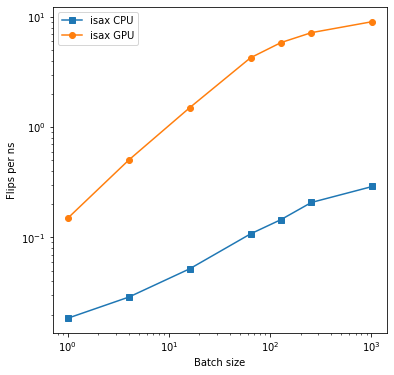

In [10]:
plt.figure(figsize=(6, 6))
if has_gpu:
    plt.plot(batch_sizes, flips_per_ns_gpu, label="isax GPU", marker="o")
plt.plot(batch_sizes, flips_per_ns_cpu, label="isax CPU", marker="s")
plt.legend()
plt.xlabel("Batch size")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Flips per ns")
plt.show()